# RDRS Forcing update
Cyril identified that forcing processing for RDRS at least seems to have gone wrong. Streamflow data cover a longer time period than the forcing data. He found basin CAN_02HC038. Manual checks show that this plays a role in more basins. Here I get the extents for those so we can re-do the RDRS subsetting.

In [1]:
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from contextlib import redirect_stdout, redirect_stderr
from datetime import datetime,timedelta 
import geopandas as gpd
import glob
import math
import matplotlib.pyplot as plt
from multiprocessing import Process
import netCDF4 as nc4
import numpy as np
import os
import pandas as pd
from pathlib import Path
import psutil
import shutil
import time
import warnings
import xarray as xr

import sys
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs
from python_cs_functions import attributes as csa

In [2]:
# Figure out which easymore version we're dealing with and load accordingly
import pkg_resources

def get_package_version(package_name):
    try:
        version = pkg_resources.get_distribution(package_name).version
        return version
    except pkg_resources.DistributionNotFound:
        return f"Package '{package_name}' not found."

package_name = 'easymore'
esmr_version = get_package_version(package_name)
print(f"The version of {package_name} is {esmr_version}")

The version of easymore is 2.0.0


## File locations

In [3]:
# Data location
cs_main_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload")

In [4]:
cs_update_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates/")

In [5]:
cs_meta = pd.read_csv(cs_update_folder / "camels-spat-metadata.csv")

In [6]:
basins = ['CAN_02GA038','CAN_02GA041','CAN_02GA043','CAN_02GC002','CAN_02GC010','CAN_02GC018','CAN_02GC021','CAN_02GC029','CAN_02GC030',
          'CAN_02GC031','CAN_02GD004','CAN_02GD010','CAN_02GD019','CAN_02GD021','CAN_02GE007','CAN_02GG002','CAN_02GG003','CAN_02GG005',
          'CAN_02GG006','CAN_02GG009','CAN_02GH002','CAN_02HA006','CAN_02HA020','CAN_02HB012','CAN_02HB022','CAN_02HB023','CAN_02HC019',
          'CAN_02HC023','CAN_02HC025','CAN_02HC038']

## Identify issue
Loop over basins and:
- Find out Qobs extent from files
- Check forcing data coverage for all data sets
- Find spatial extent from shapefile + buffer

In [6]:
basins = ['CAN_02GA038','CAN_02GA041','CAN_02GA043','CAN_02GC002','CAN_02GC010','CAN_02GC018','CAN_02GC021','CAN_02GC029','CAN_02GC030',
          'CAN_02GC031','CAN_02GD004','CAN_02GD010','CAN_02GD019','CAN_02GD021','CAN_02GE007','CAN_02GG002','CAN_02GG003','CAN_02GG005',
          'CAN_02GG006','CAN_02GG009','CAN_02GH002','CAN_02HA006','CAN_02HA020','CAN_02HB012','CAN_02HB022','CAN_02HB023','CAN_02HC019',
          'CAN_02HC023','CAN_02HC025','CAN_02HC038']

In [18]:
# Specify the folder structure
path_part1 = "forcing"
# path_part2 from metadata
path_parts3 = ["daymet", "em-earth", "era5", "rdrs"]
path_parts4 = ["gridded", "distributed", "lumped"]
basin = "CAN_02HC038"

In [17]:
# RDRS data availbility
rdrs_s = datetime(1980,1,1,12,0)
rdrs_e = datetime(2018,12,30,12,0)

In [20]:
l_start = []
l_end = []
l_extent = []

In [21]:
for basin in basins:

    # ID the basin
    row = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0]
    path_part2 = row['subset_category']

    # Find the observations
    qobs_d = xr.open_dataset(cs_update_folder / "observations" / path_part2 / "obs-daily" / f"{basin}_daily_flow_observations.nc")
    qobs_h = xr.open_dataset(cs_update_folder / "observations" / path_part2 / "obs-hourly" / f"{basin}_hourly_flow_observations.nc")
    ts = min(qobs_d['time'][0].values,qobs_h['time'][0].values)
    te = max(qobs_d['time'][-1].values,qobs_h['time'][-1].values)  
    qobs_d.close()
    qobs_h.close()

    # define times
    if pd.to_datetime(ts) < rdrs_s:
            start_date = rdrs_s
    if pd.to_datetime(te) > rdrs_e:
        final_date = rdrs_e
    dt_start_date = start_date.strftime('%Y-%m-%d %H:%M:%S')
    dt_final_date = final_date.strftime('%Y-%m-%d %H:%M:%S')

    # Check the forcing coverage
    print(f"\n{basin}: Looking for:\n{ts}\n{te}")
    
    for path_part3 in path_parts3:
        print(f"\n{path_part3}:")
        
        for path_part4 in path_parts4:
            full_path = cs_main_folder / path_part1 / path_part2 / path_part3 / f"{path_part3}-{path_part4}"
            tmp = path_part3.replace("-","_") # em-earth to em_earth
            file_name = f"{basin}_{tmp}_{path_part4}.nc"
            ds = xr.open_dataset(full_path / file_name)
            print(f"{path_part4:<11} start:  {ds['time'][0].values}")
            print(f"{path_part4:<11} end  :  {ds['time'][-1].values}")
            ds.close()

    # Get the spatial extent
    shp_lump_path = cs_main_folder / 'shapefiles' / path_part2 / 'shapes-lumped' / f"{basin}" / f"{basin}_lumped.shp"
    shp = gpd.read_file(shp_lump_path)
    bounds = shp.total_bounds
    
    station_lat = row['Station_lat']
    lat_buffer = 0.08983
    lat = math.radians(row['Station_lat'])
    lon_buffer = 10/(111.32 * math.cos(lat))

    n_buffer = 3
    bounds[0] = bounds[0] - n_buffer*lon_buffer
    bounds[1] = bounds[1] - n_buffer*lat_buffer
    bounds[2] = bounds[2] + n_buffer*lon_buffer
    bounds[3] = bounds[3] + n_buffer*lat_buffer

    # Store
    l_start.append(dt_start_date)
    l_end.append(dt_final_date)
    l_extent.append(bounds)


CAN_02GA038: Looking for:
1972-02-01T00:00:00.000000000
2023-01-02T23:00:00.000000000

daymet:
gridded     start:  1980-01-01T12:00:00.000000000
gridded     end  :  2023-12-31T12:00:00.000000000
distributed start:  1980-01-01T12:00:00.000000000
distributed end  :  2023-12-31T12:00:00.000000000
lumped      start:  1980-01-01T12:00:00.000000000
lumped      end  :  2023-12-31T12:00:00.000000000

em-earth:
gridded     start:  1972-01-31T19:00:00.000000000
gridded     end  :  2019-12-31T18:00:00.000000000
distributed start:  1972-01-31T19:00:00.000000000
distributed end  :  2019-12-31T18:00:00.000000000
lumped      start:  1972-01-31T19:00:00.000000000
lumped      end  :  2019-12-31T18:00:00.000000000

era5:
gridded     start:  1972-01-31T19:00:00.000000000
gridded     end  :  2023-01-03T18:00:00.000000000
distributed start:  1972-01-31T19:00:00.000000000
distributed end  :  2023-01-03T18:00:00.000000000
lumped      start:  1972-01-31T19:00:00.000000000
lumped      end  :  2023-01-03T18:00

In [26]:
df = pd.DataFrame(data={'basin': basins, 'start':l_start, 'end':l_end, 'extent':l_extent})

In [27]:
df.to_csv('rdrs_updates.csv',index=False)

## Processing

### 1. Subsetting to basin
Kasra ran this on ARC. Files moved to:
`/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/]basin]`

### 2. Process in parallel

In [6]:
def generate_expected_dates(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS') # months
    dates = [f"{date.strftime('%Y-%m')}" for date in date_range]
    return dates

In [7]:
def extract_dates_from_filenames(files):
    return [file[-10:-3] for file in files]

In [8]:
def log_message(log_path, message):
    with open(log_path, "a") as f:
        f.write(message + "\n")

In [9]:
def check_netcdf_compatibility(file1, file2, file3, expected_vars, expected_time_steps):
    """
    Opens three NetCDF files and checks if they:
    - Cover the same time period.
    - Contain the expected variables (also ensures variables have a 'time' dimension).
    - Have the expected number of time steps.

    Parameters:
    - file1, file2, file3 (str): File paths to the NetCDF files.
    - expected_vars (list): List of expected variables that should have a "time" dimension.
    - expected_time_steps (int): Expected number of time steps in each file.

    Returns:
    - dict: A dictionary with results for time period matching, variable existence, and time step count.
    """

    # Open the NetCDF files
    ds1 = xr.open_dataset(file1, engine='netcdf4')
    ds2 = xr.open_dataset(file2, engine='netcdf4')
    ds3 = xr.open_dataset(file3, engine='netcdf4')

    # Extract time ranges (if time exists in dataset)
    time_range1 = (ds1["time"].min().values, ds1["time"].max().values) if "time" in ds1 else None
    time_range2 = (ds2["time"].min().values, ds2["time"].max().values) if "time" in ds2 else None
    time_range3 = (ds3["time"].min().values, ds3["time"].max().values) if "time" in ds3 else None

    # Check if time periods match
    time_match = (time_range1 == time_range2 == time_range3)

    # Extract the number of time steps in each dataset
    time_steps1 = len(ds1["time"]) if "time" in ds1 else None
    time_steps2 = len(ds2["time"]) if "time" in ds2 else None
    time_steps3 = len(ds3["time"]) if "time" in ds3 else None

    # Check if time step counts match the expected value
    time_step_match = (time_steps1 == time_steps2 == time_steps3 == expected_time_steps)

    # Check if expected variables exist in each dataset
    var_existence = {
        var: {
            "file1": var in ds1.data_vars and "time" in ds1[var].dims,
            "file2": var in ds2.data_vars and "time" in ds2[var].dims,
            "file3": var in ds3.data_vars and "time" in ds3[var].dims,
        }
        for var in expected_vars
    }

    # Find any missing variables
    missing_vars = {
        var: [file for file in ["file1", "file2", "file3"] if not var_existence[var][file]]
        for var in expected_vars
        if not all(var_existence[var].values())  # Only keep variables that are missing in at least one file
    }

    # Find any files with incorrect time step count
    incorrect_time_steps = {
        file: actual_steps
        for file, actual_steps in {
            "file1": time_steps1,
            "file2": time_steps2,
            "file3": time_steps3,
        }.items()
        if actual_steps != expected_time_steps
    }

    # Raise assertion error if any expected variable is missing in any file
    assert not missing_vars, f"Missing expected variables in files: {missing_vars}"

    # Raise assertion error if any file has an incorrect number of time steps
    assert not incorrect_time_steps, f"Incorrect time steps in files: {incorrect_time_steps}. Expected {expected_time_steps}."

    # Close datasets to release file handles
    ds1.close()
    ds2.close()
    ds3.close()

    return

In [10]:
def generate_encoding(nc, dim_order, time_chunk=100):
    """
    Generates an encoding dictionary for NetCDF compression and chunking.

    Parameters:
    - nc (xr.Dataset): Xarray dataset containing the variables and dimensions.
    - dim_order (tuple): Tuple specifying the expected dimension order (e.g., ("time", "rlat", "rlon")).
    - time_chunk (int): Chunk size for the "time" dimension.

    Returns:
    - dict: Encoding dictionary for use with `to_netcdf()`, ensuring 'source' and 'coordinates' are removed.
    """

    # Create chunk_sizes where "time" has "time_chunk" size, and other dimensions keep their full length
    chunk_sizes = tuple(time_chunk if dim == "time" else nc.dims[dim] for dim in dim_order)

    # Find variables that match the specified dimension order
    matching_vars = [var for var in nc.data_vars if nc[var].dims == dim_order]

    # Construct encoding dictionary, preserving existing settings
    encoding = {}
    for var in matching_vars:
        # Copy existing encoding or start with an empty dict
        existing_encoding = nc[var].encoding.copy()

        # Update only the necessary keys
        updated_encoding = {
            **existing_encoding,  # Retain existing encoding
            "zlib": True,
            "complevel": 4,
            "chunksizes": chunk_sizes,
        }

        # Remove unwanted encoding keys
        for key in ["source", "coordinates"]:
            updated_encoding.pop(key, None)  # Remove if exists

        # Assign updated encoding back to dictionary
        encoding[var] = updated_encoding

    return encoding

In [11]:
def merge_daily_to_monthly(input_dir: str, output_dir: str, variables_to_keep=None,
                           dev_flag=False):
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Compression settings
    comp = dict(zlib=True, complevel=4)  # Use zlib compression with level 4

    # Gather all NetCDF files in the input directory
    files = [f for f in os.listdir(input_dir) if f.endswith('12.nc')]
    files.sort()

    # Group files by month
    monthly_files = defaultdict(list)
    for file in files:
        # Extract date from filename
        date_str = file.split('_')[-1].split('.')[0][:8]  # Assumes the format is country_basin_subset_yyyymmdd12.nc
        date = datetime.strptime(date_str, '%Y%m%d')
        month_key = date.strftime('%Y-%m')
        monthly_files[month_key].append(file)

    # DEV: limit to 2 months
    if dev_flag:
        first_two = {k: monthly_files[k] for k in list(monthly_files)[:2]}
        monthly_files = first_two

    # Loop over the months and concatenate
    for yyyymm, files in monthly_files.items():
        output_file = os.path.join(output_dir, f'RDRS_{yyyymm}.nc')

        # Skip if the file already exists
        #if os.path.exists(output_file) and not overWrite:
        #    print(f"File already exists: {output_file}")
        #    return # out of function

        # Process each file in the month
        datasets = []
        for file in files:
            filepath = os.path.join(input_dir, file)
            tmp_ds = xr.open_dataset(filepath, engine='netcdf4')
            if variables_to_keep is not None:
                variables_to_drop = [var for var in tmp_ds.variables if (var not in variables_to_keep and (var not in tmp_ds.coords)) and (var != 'rotated_pole')]
                tmp_ds = tmp_ds.drop_vars(variables_to_drop)
            datasets.append(tmp_ds)

        # Merge the datasets
        ds = xr.concat(datasets, dim='time')
        encoding = {var: comp for var in ds.data_vars}
        ds.to_netcdf(output_file, mode='w', encoding=encoding)
        ds.close()
        #print(f"Saved monthly file: {output_file}")

        # Close the datasets   
        for ds in datasets:
            ds.close()

    return

In [12]:
def merge_to_monthly(basin: str, wip_path: str, dev_flag=False) -> str:
    
    # define path
    month_dir = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}/rdrs_month")
    month_dir.mkdir(exist_ok=True)
    #month_dir = str(month_dir)

    # Specify data folders
    year_folders = [f"{wip_path}/{year}" for year in range(1980,2019)]

    # DEV option to limit number of files to 1 year
    if dev_flag:
        year_folders = [f"{wip_path}/1980"]

    # Merge
    for year_folder in year_folders:
        merge_daily_to_monthly(year_folder, month_dir, dev_flag=dev_flag)

    return month_dir

In [13]:
def convert_units(month_dir, wip_path, dev_flag=False):

    # Find files
    month_files = glob.glob(str(month_dir / 'RDRS_*.nc'))
    month_files.sort()
    if not dev_flag:
        assert len(month_files) == 468, f"not all expected files found"

    # Make the gridded directory
    grid_folder = wip_path / 'gridded'
    grid_folder.mkdir(exist_ok=True)

    # Loop over the files and update the units
    for month_file in month_files:
        ds = xr.open_dataset(month_file, engine='netcdf4')
        ds = cs.convert_rdrs_variables(ds, cs.create_rdrs_unit_conversion_dict())
        filename = Path(month_file).name
        ds.to_netcdf(grid_folder/filename)
        ds.close()

    # Find the updated files
    rdrs_files = glob.glob(str(grid_folder / 'RDRS_*.nc'))
    rdrs_files.sort()

    return grid_folder, rdrs_files

In [14]:
def add_derived_variables(rdrs_files):

    # Loop over the files and add the vapor pressure and pet variables
    for rdrs_file in rdrs_files:
        with nc4.Dataset(rdrs_file, 'r+') as f:
            f = cs.derive_vapor_pressure(f, 
                                            air_pressure='RDRS_v2.1_P_P0_SFC', # in [Pa] after conversion above
                                            specific_humidity='RDRS_v2.1_P_HU_1.5m',
                                            Pa_to_kPa=True, # need to convert air pressure units
                                            new_name='e', # same as in ERA5 files
                                            dims='rlat/rlon')
            f = cs.derive_penman_monteith_pet(f,
                                                air_pressure='RDRS_v2.1_P_P0_SFC',
                                                air_temperature='RDRS_v2.1_P_TT_1.5m',
                                                relative_humidity='RDRS_v2.1_P_HR_1.5m',
                                                shortwave_radiation='RDRS_v2.1_P_FB_SFC',
                                                longwave_radiation='RDRS_v2.1_P_FI_SFC',
                                                wind_speed='RDRS_v2.1_P_UVC_10m',
                                                wind_height=10,
                                                ground_heat=0,
                                                new_name='pet',
                                                to_kg_m2_s=True)

In [15]:
def average_to_subbasins(cs_main_folder, row, basin, wip_path, grid_fold, log_path):

    # define where the shapefiles are
    shp_lump = cs_main_folder/'shapefiles'/row['subset_category']/'shapes-lumped'/basin/f"{basin}_lumped.shp"
    shp_dist = cs_main_folder/'shapefiles'/row['subset_category']/'shapes-distributed'/basin/f"{basin}_distributed_basin.shp"
    assert shp_lump.exists()
    assert shp_dist.exists()

    # define where the data needs to go
    lump_fold = wip_path / 'lumped'
    dist_fold = wip_path / 'distributed'
    temp_fold = wip_path / 'esmr_tmp'
    lump_fold.mkdir(exist_ok=True)
    dist_fold.mkdir(exist_ok=True)
    temp_fold.mkdir(exist_ok=True)

    # Do the remapping for the lumped and distributed cases
    for case, basin_shp, out_dir in zip(['lumped', 'dist'],
                                        [shp_lump, shp_dist], 
                                        [lump_fold, dist_fold]):
    
        # Define the EASYMORE inputs
        esmr,_ = cs.get_easymore_settings('RDRS', case, None, basin_shp, temp_fold, out_dir,
                                          in_files=str(grid_fold / 'RDRS_*.nc'), 
                                          version=esmr_version)
        
        # Set the approximate grid resolution for cases where we only have a single grid cell
        # We'll overestimate this a little, so we don't accidentally cut part of the basin of
        # degrees 10km / 111km = 0.090 degress latitude, longitude would be smaller but we can 
        # only specify one value in EASYMORE v2.
        esmr.source_nc_resolution = 0.5 

        # Run the remapper in a sub-process to ensure it releases the file locks
        #esmr.nc_remapper()
        p = Process(target=call_remapper_safely, args=(esmr, log_path))
        p.start() # start the subprocess
        p.join() # tell parent to wait until subprocess completes

    # DEV: check if any netcdf files remain locked
    p = psutil.Process(os.getpid())
    open_files = [f.path for f in p.open_files() if f.path.endswith('.nc')]
    log_message(log_path, f"Still-open NetCDFs: {open_files}")
    
    return lump_fold, dist_fold

In [16]:
def call_remapper_safely(esmr_obj, log_path):
    with open(log_path, 'a') as log_file:
        with redirect_stdout(log_file), redirect_stderr(log_file):
            esmr_obj.nc_remapper()

In [17]:
def update_time_index(grid_fold, lump_fold, dist_fold, row, log_path):

    # Find the files now we've moved the whole thing
    grid_files = sorted(glob.glob(str(grid_fold/'RDRS*.nc'))) # list
    lump_files = sorted(glob.glob(str(lump_fold/'RDRS*.nc'))) # list
    dist_files = sorted(glob.glob(str(dist_fold/'RDRS*.nc'))) # list
    all_files = grid_files + lump_files + dist_files

    # Find LST
    # We can simply use dv_flow_obs_timezone here because we already know the USA gauges
    #  show consistent LSTs for IV and DV observations, and for CAN we only have DV LST
    #  anyway.
    lst = row['dv_flow_obs_timezone']
    if lst == 'NST':
        log_message(log_path, f'NST found for {row.Station_id}, switching to AST')
        lst = 'AST' # set Newfoundland Standard Time (UTC-3h30) to Atlantic Standard Time (UTC-4h), because we only have forcing at whole hours
    utc = cs.tz_abbreviation_to_utc(lst) # e.g. 'UTC-04'
    offset = cs.relative_utc_to_float_offset_in_hours(utc) # e.g. -4.0

    # Open files with xarray, update time values with pandas and replace in file
    for file in all_files:
       
        # create a backup copy of the file in case processing ends halfway through a file
        backup_file = file.replace('.nc','_BACKUP.nc')
        shutil.copy2(file,backup_file)
        
        # Update times
        with nc4.Dataset(file, 'a') as f:
    
            # Check if these times were already updated
            hist_string = f"updated time index from UTC to {lst}"
            if 'History' in f.ncattrs():
                if hist_string in f.History:
                    log_message(log_path, f"{file}:\n  History indicates times were already updates")
                    os.remove(backup_file)
                    continue
            elif 'history' in f.ncattrs():
                if hist_string in f.history:
                    log_message(log_path, f"{file}:\n  History indicates times were already updates")
                    os.remove(backup_file)
                    continue
            
            # If not, shift times
            time_variable = f.variables['time']
            time_variable[:] = time_variable[:] + offset
    
            # Track what we did
            history = f' On {time.ctime(time.time())}: updated time index from UTC to {lst}.'
            if 'History' in f.ncattrs():
                current_history = f.getncattr('History')
                new_history = f'{current_history}{history}'
                f.setncattr('History', new_history)
            elif 'history' in f.ncattrs():
                current_history = f.getncattr('history')
                new_history = f'{current_history}{history}'
                f.setncattr('history', new_history)
        
        # Remove the backup
        os.remove(backup_file)

    return all_files, lst

In [18]:
def add_time_bounds(all_files, lst):
    # Open files, add time_bnds, and close
    for file in all_files:
        if 'rdrs' in file.lower():
            cs.add_time_bnds(file,'rdrs',lst)

In [19]:
def add_wind_dir(all_files):
    # Loop over the files and add new variables
    for file in all_files:
        with nc4.Dataset(file, 'r+') as f:
            # Add wind direction, function argument 'dims' toggles a switch away from
            #  default behavior in make_nc_variable() which assumes lat & lon dims exist
            if 'hru' in f.dimensions:
                f = cs.derive_wind_direction(f, 
                                             u_wind='RDRS_v2.1_P_UUC_10m', 
                                             v_wind='RDRS_v2.1_P_VVC_10m', 
                                             dims='hru',       
                                             overwrite=True)
            else:
                f = cs.derive_wind_direction(f, 
                                             u_wind='RDRS_v2.1_P_UUC_10m', 
                                             v_wind='RDRS_v2.1_P_VVC_10m', 
                                             dims='rlat/rlon', 
                                             overwrite=True)

In [20]:
def rdrs_checks(grid_folder, lump_folder, dist_folder):

    for subfolder in [grid_folder, lump_folder, dist_folder]:

        # Find the files
        rdrs_files = glob.glob(str(subfolder / 'RDRS_*.nc'))
        rdrs_files.sort() # critical for later checks
        
        # - Begin checks
        # Do we have data at all?
        assert len(rdrs_files) > 0, f"Missing {subfolder} files for {basin_id}"
    
        # Do we have all months between first and last?
        # raw file example: RDRS_1980-01.nc
        # lumped file example: RDRS_lumped_remapped_RDRS_1980-01.nc
        # distributed file example: RDRS_dist_remapped_RDRS_1980-01.nc
        start_date = rdrs_files[0][-10:-3]
        final_date = rdrs_files[-1][-10:-3]
        want_dates = generate_expected_dates(start_date, final_date)
        have_dates = extract_dates_from_filenames(rdrs_files)
        assert want_dates == have_dates, f"Missing month(s) in {subfolder} files for {basin_id}"
    
        # Loop over the files for internal checks
        times = []
        for i, file in enumerate(rdrs_files):
            data = xr.open_dataset(file, engine='netcdf4')
    
            # Check for the required variables
            for var in ['RDRS_v2.1_A_PR0_SFC', 'RDRS_v2.1_P_FB_SFC', 'RDRS_v2.1_P_FI_SFC',
                        'pet', 'RDRS_v2.1_P_TT_1.5m', 'RDRS_v2.1_P_P0_SFC', 'RDRS_v2.1_P_HU_1.5m',
                        'RDRS_v2.1_P_HR_1.5m', 'e', 'RDRS_v2.1_P_UUC_10m', 'RDRS_v2.1_P_VVC_10m',
                        'RDRS_v2.1_P_UVC_10m', 'phi', 'time', 'time_bnds']:
                assert var in data, f"Missing {var} in {file} for {basin_id}"
    
            # Check for NaNs in the lumped and distributed cases
            if subfolder == lump_folder or subfolder == dist_folder:
                for var in ['RDRS_v2.1_A_PR0_SFC', 'RDRS_v2.1_P_FB_SFC', 'RDRS_v2.1_P_FI_SFC',
                        'pet', 'RDRS_v2.1_P_TT_1.5m', 'RDRS_v2.1_P_P0_SFC', 'RDRS_v2.1_P_HU_1.5m',
                        'RDRS_v2.1_P_HR_1.5m', 'e', 'RDRS_v2.1_P_UUC_10m', 'RDRS_v2.1_P_VVC_10m',
                        'RDRS_v2.1_P_UVC_10m', 'phi']:
                    assert data[var].isnull().sum() == 0, f"NaNs in {var} in {file} for {basin_id}"
    
            # Check for only 1 HRU in the lumped case
            if subfolder == lump_folder:
                assert data['hru'].shape[0] == 1, f"More than 1 HRU in {file} for {basin_id}"
    
            # Check for consecutive dates by concatenating the dates from all files
            times.append(data['time'].values) # list of arrays of datetimes
    
            # Close the file
            data.close()
        
        # Check for consecutive dates
        # This implicitly also checks if we added the missing days in leap years correctly
        datetimes = np.concatenate(times) # array of datetimes
        expected_datetimes = pd.date_range(start=datetimes[0], end=datetimes[-1], freq='H')
        assert (datetimes == expected_datetimes).all(), f"Non-consecutive dates in {subfolder} files for {basin_id}"
    

In [21]:
def merge_and_check(wip_path, basin, grid_folder, lump_folder, dist_folder):

    # Create the folder where we'll put the merged files
    merge_fold = wip_path / 'merged'
    merge_fold.mkdir(exist_ok=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)

        # gridded
        dst1 = merge_fold / f"{basin}_rdrs_gridded.nc"
        src_files = glob.glob(str(grid_folder / f"RDRS*.nc"))
        nc = xr.open_mfdataset(src_files, combine="by_coords", engine='netcdf4')
        expected_length = len(nc['time']) # used later to check
        encoding = generate_encoding(nc,("time", "rlat", "rlon"))
        nc.to_netcdf(dst1, encoding=encoding)
        nc.close()
        
        # lumped
        dst2 = merge_fold / f"{basin}_rdrs_lumped.nc"
        src_files = glob.glob(str(lump_folder / f"RDRS*.nc"))
        nc = xr.open_mfdataset(src_files, combine="by_coords", engine='netcdf4')
        encoding = generate_encoding(nc,("time", "hru"))
        nc.to_netcdf(dst2, encoding=encoding)
        nc.close()
        
        # distributed
        dst3 = merge_fold / f"{basin}_rdrs_distributed.nc"
        src_files = glob.glob(str(dist_folder / f"RDRS*.nc"))
        nc = xr.open_mfdataset(src_files, combine="by_coords", engine='netcdf4')
        encoding = generate_encoding(nc,("time", "hru"))
        nc.to_netcdf(dst3, encoding=encoding)
        nc.close()
    
        # Check
        expected_vars = ['RDRS_v2.1_P_P0_SFC','RDRS_v2.1_P_TT_1.5m','RDRS_v2.1_P_HU_1.5m',
                         'RDRS_v2.1_P_HR_1.5m','RDRS_v2.1_P_UUC_10m','RDRS_v2.1_P_VVC_10m',
                         'RDRS_v2.1_P_UVC_10m','RDRS_v2.1_P_FI_SFC','RDRS_v2.1_P_FB_SFC',
                         'RDRS_v2.1_P_GZ_SFC','RDRS_v2.1_A_PR0_SFC','e','pet','phi','time_bnds']
        check_netcdf_compatibility(dst1, dst2, dst3, expected_vars, expected_length)
    

In [22]:
# Wrap the processing in a function that simply accepts an index
def process_basin(basin):

    dev_flag = False # runs only a handful of files instead of all of them

    # 2.1. Setup
    row = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0] # meta data
    wip_path = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}") # should exist from file transfer
    log_path = wip_path / f"log_{basin}.txt" # Define the log path
    log_message(log_path, f"Processing {basin}")
    
    # 2.2. Merge daily to monthly files
    month_dir = merge_to_monthly(basin, wip_path, dev_flag=dev_flag)
    log_message(log_path, f"Finished merging for {basin}")

    # 2.3. Convert units
    grid_folder, rdrs_files = convert_units(month_dir, wip_path, dev_flag=dev_flag)
    log_message(log_path, f"Finished updating units")

    # 2.4. Add PET and vapor pressure
    add_derived_variables(rdrs_files)
    log_message(log_path, f"Finished adding vapor pressure and pet")

    # 2.5. Average to subbasins
    with open(f"{basin}_spam.txt", 'w') as log_file:
        with redirect_stdout(log_file), redirect_stderr(log_file): # captures easymore spam
            lump_folder, dist_folder = average_to_subbasins(
                cs_main_folder, row, basin, wip_path, grid_folder, log_path
            )
    log_message(log_path, f"Finished regridding")

    # 2.6. Update time index
    all_files, lst = update_time_index(grid_folder, lump_folder, dist_folder, row, log_path)
    log_message(log_path, f"Finished updating time index")

    # 2.7. Add time bounds
    add_time_bounds(all_files, lst)
    log_message(log_path, f"Finished adding time_bnds")

    # 2.8. Add wind direction
    add_wind_dir(all_files)
    log_message(log_path, f"Finished adding wind direction")

    # 2.9. Run the checks
    rdrs_checks(grid_folder, lump_folder, dist_folder)
    log_message(log_path, f"Finished running checks")

    # 2.10. Merge files
    merge_and_check(wip_path, basin, grid_folder, lump_folder, dist_folder)
    log_message(log_path, f"Finished RDRS processing for {basin}")
    
    return basin

In [23]:
# Temporarily filter out future warnings
# This stops some warnings from being printed to the console
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [24]:
basins = ['CAN_02GA038','CAN_02GA041','CAN_02GA043','CAN_02GC002','CAN_02GC010','CAN_02GC018','CAN_02GC021','CAN_02GC029','CAN_02GC030',
          'CAN_02GC031','CAN_02GD004','CAN_02GD010','CAN_02GD019','CAN_02GD021','CAN_02GE007','CAN_02GG002','CAN_02GG003','CAN_02GG005',
          'CAN_02GG006','CAN_02GG009','CAN_02GH002','CAN_02HA006','CAN_02HA020','CAN_02HB012','CAN_02HB022','CAN_02HB023','CAN_02HC019',
          'CAN_02HC023','CAN_02HC025','CAN_02HC038']

In [25]:
# Set the cache with a quick xr.open_dataset() call
# This hopefully stops race conditions when all the workers try to get into entry_points()
dummy = '/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02GA038/1980/CAN_02GA038_subset_1980010112.nc'
xr.open_dataset(dummy, engine='netcdf4').close()

In [26]:
with ProcessPoolExecutor(max_workers=30) as executor:
    results = list(executor.map(process_basin, basins))

In [27]:
len(results)

30

In [30]:
# Clean up dev results
'''
for basin in basins:
    bf = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}")
    
    for ff in ["distributed","esmr_tmp","gridded","lumped","merged","rdrs_month"]:
        if os.path.exists(bf/ff):
            shutil.rmtree(bf/ff)
    if os.path.isfile(bf/f"log_{basin}.txt"):
        os.remove(bf/f"log_{basin}.txt")
'''

1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-01T08:00:00.000000000 - 2018-12-31T07:00:00.000000000
1980-01-

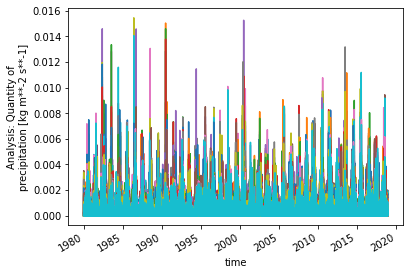

In [30]:
# Check that we ended up with some timeseries
for basin in basins:
    fp = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}")
    fp = fp / 'merged' / f"{basin}_rdrs_lumped.nc"
    ds = xr.open_dataset(fp, engine='netcdf4')
    ds['RDRS_v2.1_A_PR0_SFC'].plot()
    print(f"{ds['time'][0].values} - {ds['time'][-1].values}")
    ds.close()

#### Dev (serial)

### 2. Merge to monthly files
We're just sticking with existing processing steps.

In [9]:
basins = ['CAN_02GA038','CAN_02GA041','CAN_02GA043','CAN_02GC002','CAN_02GC010','CAN_02GC018','CAN_02GC021','CAN_02GC029','CAN_02GC030',
          'CAN_02GC031','CAN_02GD004','CAN_02GD010','CAN_02GD019','CAN_02GD021','CAN_02GE007','CAN_02GG002','CAN_02GG003','CAN_02GG005',
          'CAN_02GG006','CAN_02GG009','CAN_02GH002','CAN_02HA006','CAN_02HA020','CAN_02HB012','CAN_02HB022','CAN_02HB023','CAN_02HC019',
          'CAN_02HC023','CAN_02HC025','CAN_02HC038']

In [10]:
basin = basins[-1] # DEV, the one that's already complete
basin

'CAN_02HC038'

In [11]:
# cs_meta
row = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0]

In [12]:
# paths
wip_path = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}")
month_dir = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}/rdrs_month")
month_dir.mkdir(exist_ok=True)

In [33]:
# get the yearly folders
year_folders = [f"{wip_path}/{year}" for year in range(1980,2019)]

In [40]:
for year_folder in year_folders:
    merge_daily_to_monthly(year_folder, month_dir)
print(f"Finished merging for {basin}")

Processing month: 1980-01 into /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-01.nc
Saved monthly file: /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-01.nc
Processing month: 1980-02 into /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-02.nc
Saved monthly file: /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-02.nc
Processing month: 1980-03 into /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-03.nc
Saved monthly file: /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-03.nc
Processing month: 1980-04 into /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-04.nc
Saved monthly file: /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/rdrs_month/RDRS_1980-04.nc
Processing month: 1980-05 into /scratch/gwf/gwf_cmt/wknoben/

### 3. Convert units and add derived values

In [70]:
# Get the files
month_files = glob.glob(str(month_dir / 'RDRS_*.nc'))
month_files.sort()
assert len(month_files) == 468, f"{basin}: not all expected files found"

In [15]:
# Make the gridded directory
grid_folder = wip_path / 'gridded'
grid_folder.mkdir(exist_ok=True)

In [72]:
# Loop over the files and update the units
for month_file in month_files:
    ds = xr.open_dataset(month_file)
    ds = cs.convert_rdrs_variables(ds, cs.create_rdrs_unit_conversion_dict())
    filename = Path(month_file).name
    ds.to_netcdf(grid_folder/filename)

In [73]:
# Find the updated files
rdrs_files = glob.glob(str(grid_folder / 'RDRS_*.nc'))
rdrs_files.sort()

In [74]:
# Loop over the files and add the vapor pressure and pet variables
for rdrs_file in rdrs_files:
    with nc4.Dataset(rdrs_file, 'r+') as f:
        f = cs.derive_vapor_pressure(f, 
                                        air_pressure='RDRS_v2.1_P_P0_SFC', # in [Pa] after conversion above
                                        specific_humidity='RDRS_v2.1_P_HU_1.5m',
                                        Pa_to_kPa=True, # need to convert air pressure units
                                        new_name='e', # same as in ERA5 files
                                        dims='rlat/rlon')
        f = cs.derive_penman_monteith_pet(f,
                                            air_pressure='RDRS_v2.1_P_P0_SFC',
                                            air_temperature='RDRS_v2.1_P_TT_1.5m',
                                            relative_humidity='RDRS_v2.1_P_HR_1.5m',
                                            shortwave_radiation='RDRS_v2.1_P_FB_SFC',
                                            longwave_radiation='RDRS_v2.1_P_FI_SFC',
                                            wind_speed='RDRS_v2.1_P_UVC_10m',
                                            wind_height=10,
                                            ground_heat=0,
                                            new_name='pet',
                                            to_kg_m2_s=True)

### 4. Average to subbasins

In [86]:
# define where the shapefiles are
shp_lump = cs_main_folder/'shapefiles'/row['subset_category']/'shapes-lumped'/basin/f"{basin}_lumped.shp"
shp_dist = cs_main_folder/'shapefiles'/row['subset_category']/'shapes-distributed'/basin/f"{basin}_distributed_basin.shp"
assert shp_lump.exists()
assert shp_dist.exists()

In [13]:
# define where the data needs to go
lump_fold = wip_path / 'lumped'
dist_fold = wip_path / 'distributed'
temp_fold = wip_path / 'esmr_tmp'
lump_fold.mkdir(exist_ok=True)
dist_fold.mkdir(exist_ok=True)
temp_fold.mkdir(exist_ok=True)

In [90]:
# Temporarily filter out future warnings
# This stops some warnings from being printed to the console
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [95]:
# Do the remapping for the lumped and distributed cases
for case, basin_shp, out_dir in zip(['lumped', 'dist'],
                                    [shp_lump, shp_dist], 
                                    [lump_fold, dist_fold]):

    # Define the EASYMORE inputs
    esmr,_ = cs.get_easymore_settings('RDRS', case, None, basin_shp, temp_fold, out_dir,
                                      in_files=str(grid_folder / 'RDRS_*.nc'), 
                                      version=esmr_version)
    
    # Set the approximate grid resolution for cases where we only have a single grid cell
    # We'll overestimate this a little, so we don't accidentally cut part of the basin of
    # degrees 10km / 111km = 0.090 degress latitude, longitude would be smaller but we can 
    # only specify one value in EASYMORE v2.
    esmr.source_nc_resolution = 0.5 
    esmr.nc_remapper()

EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  RDRS_v2.1_A_PR0_SFC  from source file to variable  RDRS_v2.1_A_PR0_SFC  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_FB_SFC  from source file to variable  RDRS_v2.1_P_FB_SFC  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_FI_SFC  from source file to variable  RDRS_v2.1_P_FI_SFC  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_GZ_SFC  from source file to variable  RDRS_v2.1_P_GZ_SFC  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_HR_1.5m  from source file to variable  RDRS_v2.1_P_HR_1.5m  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_HU_1.5m  from source file to variable  RDRS_v2.1_P_HU_1.5m  in remapped netCDF file
EASYMORE will remap variable  RDRS_v2.1_P_P0_

/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Ended at date and time 2025-06-06 18:09:58.258751
It took 0.397153 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-01.nc to /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/lumped/RDRS_lumped_remapped_RDRS_1980-01.nc 
Started at date and time 2025-06-06 18:09:58.281476 
Ended at date and time 2025-06-06 18:10:30.479801 
It took 32.198325 seconds to finish the remapping of variable(s) 
---------------------
Remapping /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-02.nc to /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/lumped/RDRS_lumped_remapped_RDRS_1980-02.nc 
Started at date and time 2025-06-06 18:10:30.486860 
Ended at date and time 2025-06-06 18:11:00.560239 
It took 30.073379 seconds to finish the remapping of variable(s) 

/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/

Ended at date and time 2025-06-06 22:22:13.702288
It took 0.421252 seconds to finish creating of the remapping file
---------------------------
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-01.nc to /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/distributed/RDRS_dist_remapped_RDRS_1980-01.nc 
Started at date and time 2025-06-06 22:22:13.732315 
Ended at date and time 2025-06-06 22:22:46.217666 
It took 32.485351 seconds to finish the remapping of variable(s) 
---------------------
Remapping /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-02.nc to /scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/distributed/RDRS_dist_remapped_RDRS_1980-02.nc 
Started at date and time 2025-06-06 22:22:46.224287 
Ended at date and time 2025-06-06 22:23:16.587886 
It took 30.363599 seconds to finish the remapping of variab

### 5. Time index

In [31]:
# Find the files now we've moved the whole thing
grid_files = sorted(glob.glob(str(grid_folder/'RDRS*.nc'))) # list
lump_files = sorted(glob.glob(str(lump_fold/'RDRS*.nc'))) # list
dist_files = sorted(glob.glob(str(dist_fold/'RDRS*.nc'))) # list
all_files = grid_files + lump_files + dist_files

In [17]:
# Find LST
# We can simply use dv_flow_obs_timezone here because we already know the USA gauges
#  show consistent LSTs for IV and DV observations, and for CAN we only have DV LST
#  anyway.
lst = row['dv_flow_obs_timezone']
if lst == 'NST':
    print(f'NST found for {row.Station_id}, switching to AST')
    lst = 'AST' # set Newfoundland Standard Time (UTC-3h30) to Atlantic Standard Time (UTC-4h), because we only have forcing at whole hours
utc = cs.tz_abbreviation_to_utc(lst) # e.g. 'UTC-04'
offset = cs.relative_utc_to_float_offset_in_hours(utc) # e.g. -4.0

In [32]:
# Open files with xarray, update time values with pandas and replace in file
for file in all_files:
   
    # create a backup copy of the file in case processing ends halfway through a file
    backup_file = file.replace('.nc','_BACKUP.nc')
    shutil.copy2(file,backup_file)
    
    # Update times
    with nc4.Dataset(file, 'a') as f:

        # Check if these times were already updated
        hist_string = f"updated time index from UTC to {lst}"
        if 'History' in f.ncattrs():
            if hist_string in f.History:
                print(f"{file}:\n  History indicates times were already updates")
                os.remove(backup_file)
                continue
        elif 'history' in f.ncattrs():
            if hist_string in f.history:
                print(f"{file}:\n  History indicates times were already updates")
                os.remove(backup_file)
                continue
        
        # If not, shift times
        time_variable = f.variables['time']
        time_variable[:] = time_variable[:] + offset

        # Track what we did
        history = f' On {time.ctime(time.time())}: updated time index from UTC to {lst}.'
        if 'History' in f.ncattrs():
            current_history = f.getncattr('History')
            new_history = f'{current_history}{history}'
            f.setncattr('History', new_history)
        elif 'history' in f.ncattrs():
            current_history = f.getncattr('history')
            new_history = f'{current_history}{history}'
            f.setncattr('history', new_history)
    
    # Remove the backup
    os.remove(backup_file)

/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-01.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-02.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-03.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-04.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-05.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-06.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/CAN_02HC038/gridded/RDRS_1980-07.nc:
  History indicates times were already updates
/scratch/gwf/gwf_cmt/wknoben/camels-spat-

### 6. Add time bounds

In [35]:
# Open files, add time_bnds, and close
for file in all_files:
    if 'rdrs' in file.lower():
        cs.add_time_bnds(file,'rdrs',lst)

### 7. Add wind direction

In [36]:
# Loop over the files and add new variables
for file in all_files:
    #print(f'Processing {file}')
    with nc4.Dataset(file, 'r+') as f:
        # Add wind direction, function argument 'dims' toggles a switch away from
        #  default behavior in make_nc_variable() which assumes lat & lon dims exist
        if 'hru' in f.dimensions:
            f = cs.derive_wind_direction(f, 
                                         u_wind='RDRS_v2.1_P_UUC_10m', 
                                         v_wind='RDRS_v2.1_P_VVC_10m', 
                                         dims='hru',       
                                         overwrite=True)
        else:
            f = cs.derive_wind_direction(f, 
                                         u_wind='RDRS_v2.1_P_UUC_10m', 
                                         v_wind='RDRS_v2.1_P_VVC_10m', 
                                         dims='rlat/rlon', 
                                         overwrite=True)

### 8. Checking code

In [65]:
for subfolder in [grid_folder, lump_fold, dist_fold]:

    # Find the files
    rdrs_files = glob.glob(str(subfolder / 'RDRS_*.nc'))
    rdrs_files.sort() # critical for later checks
    
    # - Begin checks
    # Do we have data at all?
    assert len(rdrs_files) > 0, f"Missing {subfolder} files for {basin_id}"

    # Do we have all months between first and last?
    # raw file example: RDRS_1980-01.nc
    # lumped file example: RDRS_lumped_remapped_RDRS_1980-01.nc
    # distributed file example: RDRS_dist_remapped_RDRS_1980-01.nc
    start_date = rdrs_files[0][-10:-3]
    final_date = rdrs_files[-1][-10:-3]
    want_dates = generate_expected_dates(start_date, final_date)
    have_dates = extract_dates_from_filenames(rdrs_files)
    assert want_dates == have_dates, f"Missing month(s) in {subfolder} files for {basin_id}"

    # Loop over the files for internal checks
    times = []
    for i, file in enumerate(rdrs_files):
        data = xr.open_dataset(file)

        # Check for the required variables
        for var in ['RDRS_v2.1_A_PR0_SFC', 'RDRS_v2.1_P_FB_SFC', 'RDRS_v2.1_P_FI_SFC',
                    'pet', 'RDRS_v2.1_P_TT_1.5m', 'RDRS_v2.1_P_P0_SFC', 'RDRS_v2.1_P_HU_1.5m',
                    'RDRS_v2.1_P_HR_1.5m', 'e', 'RDRS_v2.1_P_UUC_10m', 'RDRS_v2.1_P_VVC_10m',
                    'RDRS_v2.1_P_UVC_10m', 'phi', 'time', 'time_bnds']:
            assert var in data, f"Missing {var} in {file} for {basin_id}"

        # Check for NaNs in the lumped and distributed cases
        if subfolder == lump_fold or subfolder == dist_fold:
            for var in ['RDRS_v2.1_A_PR0_SFC', 'RDRS_v2.1_P_FB_SFC', 'RDRS_v2.1_P_FI_SFC',
                    'pet', 'RDRS_v2.1_P_TT_1.5m', 'RDRS_v2.1_P_P0_SFC', 'RDRS_v2.1_P_HU_1.5m',
                    'RDRS_v2.1_P_HR_1.5m', 'e', 'RDRS_v2.1_P_UUC_10m', 'RDRS_v2.1_P_VVC_10m',
                    'RDRS_v2.1_P_UVC_10m', 'phi']:
                assert data[var].isnull().sum() == 0, f"NaNs in {var} in {file} for {basin_id}"

        # Check for only 1 HRU in the lumped case
        if subfolder == lump_fold:
            assert data['hru'].shape[0] == 1, f"More than 1 HRU in {file} for {basin_id}"

        # Check for consecutive dates by concatenating the dates from all files
        times.append(data['time'].values) # list of arrays of datetimes

        # Close the file
        data.close()
    
    # Check for consecutive dates
    # This implicitly also checks if we added the missing days in leap years correctly
    datetimes = np.concatenate(times) # array of datetimes
    expected_datetimes = pd.date_range(start=datetimes[0], end=datetimes[-1], freq='H')
    assert (datetimes == expected_datetimes).all(), f"Non-consecutive dates in {subfolder} files for {basin_id}"

### 9. Merge files into one

In [67]:
# Create the folder where we'll put the merged files
merge_fold = wip_path / 'merged'
merge_fold.mkdir(exist_ok=True)

In [71]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

    # gridded
    dst1 = merge_fold / f"{basin}_rdrs_gridded.nc"
    src_files = glob.glob(str(grid_folder / f"RDRS*.nc"))
    nc = xr.open_mfdataset(src_files, combine="by_coords")
    expected_length = len(nc['time']) # used later to check
    encoding = generate_encoding(nc,("time", "rlat", "rlon"))
    nc.to_netcdf(dst1, encoding=encoding)
    nc.close()
    
    # lumped
    dst2 = merge_fold / f"{basin}_rdrs_lumped.nc"
    src_files = glob.glob(str(lump_fold / f"RDRS*.nc"))
    nc = xr.open_mfdataset(src_files, combine="by_coords")
    encoding = generate_encoding(nc,("time", "hru"))
    nc.to_netcdf(dst2, encoding=encoding)
    nc.close()
    
    # distributed
    dst3 = merge_fold / f"{basin}_rdrs_distributed.nc"
    src_files = glob.glob(str(dist_fold / f"RDRS*.nc"))
    nc = xr.open_mfdataset(src_files, combine="by_coords")
    encoding = generate_encoding(nc,("time", "hru"))
    nc.to_netcdf(dst3, encoding=encoding)
    nc.close()

    # Check
    expected_vars = ['RDRS_v2.1_P_P0_SFC','RDRS_v2.1_P_TT_1.5m','RDRS_v2.1_P_HU_1.5m',
                     'RDRS_v2.1_P_HR_1.5m','RDRS_v2.1_P_UUC_10m','RDRS_v2.1_P_VVC_10m',
                     'RDRS_v2.1_P_UVC_10m','RDRS_v2.1_P_FI_SFC','RDRS_v2.1_P_FB_SFC',
                     'RDRS_v2.1_P_GZ_SFC','RDRS_v2.1_A_PR0_SFC','e','pet','phi','time_bnds']
    check_netcdf_compatibility(dst1, dst2, dst3, expected_vars, expected_length)

## Move into update folder

In [38]:
for basin in basins:
    scale = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0]['subset_category']
    src = Path(f"/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip/forcing/{basin}/merged")
    for suffix in ['lumped', 'gridded', 'distributed']:
        file_name = f"{basin}_rdrs_{suffix}.nc"
        des = cs_update_folder / 'forcing' / scale / 'rdrs' / f"rdrs-{suffix}"
        des.mkdir(exist_ok=True, parents=True)
        shutil.copy(src/file_name, des/file_name)        

## Update attributes
We'll need to do this for the lumped and distributed cases separately.
We can limit this to attributes that require RDRS data (climate, plus some streamflow signatures).

In [7]:
# Specify where the forcing in the required format can be found
wip_path = Path('/scratch/gwf/gwf_cmt/wknoben/camels-spat-wip') 

#### Lumped

In [10]:
# load existing attributes file 
# Get this from the 'update' folder to retain changes we made to RR attribute units
att_old = pd.read_csv(cs_update_folder/'attributes'/'attributes-lumped.csv', 
                      index_col=[0,1,2,3],
                      low_memory=False)

In [11]:
# Loop over the basins and update the existing file as we go
for basin in basins:

    # Station data
    print(f"Processing {basin}")
    row = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0]
    scale = row['subset_category']

    # Prep inputs
    l_values = []
    l_index = []
    met_folder = wip_path / 'forcing' / basin
    shp_path = cs_main_folder/'shapefiles'/scale/'shapes-lumped'/basin/f"{basin}_lumped.shp"
    hyd_folder = cs_main_folder/'observations'/scale/'obs-daily'

    # Get attributes
    l_values, l_index, ds_precip, ds_rdrs = csa.attributes_from_rdrs(met_folder, 
                                                                 str(shp_path), 
                                                                 'rdrs', 
                                                                 l_values, 
                                                                 l_index, 
                                                                 use_mfdataset=True)
    l_values, l_index = csa.attributes_from_streamflow(hyd_folder, 
                                                   'hydrology', 
                                                   basin, 
                                                   ds_precip, 
                                                   row, 
                                                   l_values, 
                                                   l_index)

    # Create a temporary dataframe
    l_gauges = [basin,'tmp_column']
    input_dict = dict(zip(l_gauges, [l_values,l_values]))
    df_tmp = pd.DataFrame(input_dict)
    multi_index = pd.MultiIndex.from_tuples(l_index, names=['Category', 'Attribute', 'Unit', 'Source'])
    df_tmp.index = multi_index
    df_tmp = df_tmp.drop(columns=['tmp_column'], axis=1)

    # Update the existing attributes file
    assert len(df_tmp) == len(df_tmp.index.intersection(att_old.index)), f"{basin}: update rows don't match existing rows"
    att_old.update(df_tmp)

Processing CAN_02GA038
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Processing CAN_02GA041
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.19it/s]


Processing CAN_02GA043
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.03it/s]


Processing CAN_02GC002
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.37it/s]


Processing CAN_02GC010
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.41it/s]


Processing CAN_02GC018
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.56it/s]


Processing CAN_02GC021
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.28it/s]


Processing CAN_02GC029
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.31it/s]


Processing CAN_02GC030
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.29it/s]


Processing CAN_02GC031
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.97it/s]


Processing CAN_02GD004
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Processing CAN_02GD010
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.73it/s]


Processing CAN_02GD019
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.89it/s]


Processing CAN_02GD021
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.74it/s]


Processing CAN_02GE007
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.49it/s]


Processing CAN_02GG002
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Processing CAN_02GG003
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.72it/s]


Processing CAN_02GG005
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.84it/s]


Processing CAN_02GG006
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.34it/s]


Processing CAN_02GG009
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.90it/s]


Processing CAN_02GH002
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Processing CAN_02HA006
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.59it/s]


Processing CAN_02HA020
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.21it/s]


Processing CAN_02HB012
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.97it/s]


Processing CAN_02HB022
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.48it/s]


Processing CAN_02HB023
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.10it/s]


Processing CAN_02HC019
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.65it/s]


Processing CAN_02HC023
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.77it/s]


Processing CAN_02HC025
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.73it/s]


Processing CAN_02HC038
Running lumped case for RDRS data.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.86it/s]


In [12]:
# Save the updated attributes file to disk
att_old.to_csv(cs_update_folder/'attributes'/'attributes-lumped.csv')

#### Distributed

In [17]:
# Loop over the basin
for basin in basins:

    # Station data
    print(f"Processing {basin}")
    row = cs_meta[cs_meta['Station_id'] == basin[4:]].iloc[0]
    scale = row['subset_category']
    
    # Load the existing attributes
    att_old = pd.read_csv(cs_update_folder/'attributes'/scale/f"{basin}_attributes.csv", 
                          index_col=[0,1,2,3],
                          low_memory=False)

    # Prep inputs
    l_values = []
    l_index = []
    met_folder = wip_path / 'forcing' / basin
    shp_path = cs_main_folder/'shapefiles'/scale/'shapes-distributed'/basin/f"{basin}_distributed_basin.shp"
    
    # Get attributes
    l_values, l_index, l_comids, ds_rdrs = csa.attributes_from_rdrs(met_folder, 
                                                                str(shp_path), 
                                                                'rdrs', 
                                                                l_values, 
                                                                l_index, 
                                                                use_mfdataset=True)

    # Create a temporary dataframe
    df_tmp = pd.DataFrame(data = l_values, index = l_comids).transpose()
    multi_index = pd.MultiIndex.from_tuples(l_index, names=['Category','Attribute','Unit','Source'])
    df_tmp.index = multi_index

    # Update the existing attributes file
    assert len(df_tmp) == len(df_tmp.index.intersection(att_old.index)), "update rows don't match existing rows"
    att_old.update(df_tmp)

    # Save to update folder
    att_old.to_csv(cs_update_folder/'attributes'/scale/f"{basin}_attributes.csv")

Processing CAN_02GA038
Running distributed case for RDRS data.
Running subbasin 0
Running subbasin 1
Running subbasin 2
Running subbasin 3
Running subbasin 4
Running subbasin 5
Running subbasin 6
Running subbasin 7
Running subbasin 8
Processing CAN_02GA041
Running distributed case for RDRS data.
Running subbasin 0
Running subbasin 1
Running subbasin 2
Processing CAN_02GA043
Running distributed case for RDRS data.
Running subbasin 0
Processing CAN_02GC002
Running distributed case for RDRS data.
Running subbasin 0
Running subbasin 1
Running subbasin 2
Running subbasin 3
Running subbasin 4
Running subbasin 5
Running subbasin 6
Processing CAN_02GC010
Running distributed case for RDRS data.
Running subbasin 0
Running subbasin 1
Running subbasin 2
Running subbasin 3
Running subbasin 4
Processing CAN_02GC018
Running distributed case for RDRS data.
Running subbasin 0
Running subbasin 1
Running subbasin 2
Running subbasin 3
Running subbasin 4
Running subbasin 5
Running subbasin 6
Running subbas

## Re-do the climate picture

In [45]:
from fiona.crs import from_epsg
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [23]:
img_crs = 'ESRI:102008'

#### Prep the attributes

In [22]:
# Get the attributes
att = pd.read_csv("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates/attributes/attributes-lumped.csv",
                  low_memory=False)

In [30]:
# Transpose the attributes for easier merging with GDF
att = att.transpose()
headers = att.iloc[1] # we just keep the attribute name because with multiple header levels the merging fails
att = att.iloc[4:]
att.columns = headers.values.tolist()

#### Prep the shape

In [19]:
# Get the lumped basin shapefile
gdf = gpd.read_file("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates/plotting/camels_spat_all_basin_outlines.shp")

In [26]:
# Set the CRS
gdf.crs = from_epsg(4326)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/proj/9.0.0/lib/python3.10/site-packages/pyproj-3.3.0-py3.10-linux-x86_64.egg/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [27]:
# Create the variable we'll use for merging: <country>_<id>
gdf['basin_id'] = gdf.apply(lambda row: row['Country'] + '_' + row['Station_id'], axis=1)

In [28]:
# Project the basins into the projection we want for this graphic
gdf = gdf.to_crs(img_crs)

In [29]:
# Convert the polygons to point locations - these make for better plots when the figure is smaller
gdf['geometry'] = gdf['geometry'].centroid

In [33]:
# Create the climate plotting shape
att_columns = ('aridity1_mean','aridity1_std','aridity2_std','fracsnow1_mean','fracsnow1_std','fracsnow2_std')
gdf_clim = pd.merge(gdf, att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=att.index)

#### Plot

In [38]:
part1 = Path("/project/gwf/gwf_cmt/wknoben/camels_spat/camels-spat-data/TEMP_PoliticalBoundaries_Shapefile/")
border_path = part1 / 'NA_PoliticalDivisions/data/bound_p/boundaries_p_2021_v3.shp'

In [39]:
# Check if we have the boundary file and act accordingly
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    gdf_borders = gdf_borders.to_crs(img_crs)

In [40]:
def disable_box_boundaries(ax):
    ax.set_xlim([-2.5*1e6, 3.1*1e6])
    ax.set_ylim([-1.6*1e6, 3.7*1e6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [41]:
def add_histogram(ax,bbox,gdf,column,bar_scale,bins=10,extra=None):
    # Make the extra axis
    hax = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=bbox, bbox_transform=ax.transAxes, loc=4)
    
    # Add the histogram
    gdf[column].plot.hist(ax=hax, color='0.3', rwidth=bar_scale, bins=bins)#, edgecolor='w')

    # Disable top, right, and bottom spines
    hax.spines['top'].set_visible(False)
    hax.spines['right'].set_visible(False)
    hax.spines['left'].set_visible(False)

    # (Re)move y-axis ticks and labels
    hax.set_ylabel('')
    hax.set_yticks([])
    hax.set_yticklabels([]);

    # Category-specific modifications:
    if extra == 'sand_content':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    elif extra == 'sand_std':
        hax.set_xticks([50,100,150])
        hax.set_xticklabels(['50','','150'])
    elif extra == 'pet_mean':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    
    return

In [42]:
legend_scale = 0.6
legend_kwds = {'shrink':legend_scale,
               'orientation': 'horizontal', 
               'pad': 0.01}
poly_width = 0.1
poly_edge = 'k'
markersize = 10

map_color = '0.65'

hist_loc = (.8, .075, .25, .25)
hist_bar_scale = 0.75

In [43]:
# Disable deprecation warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

/tmp/ipykernel_1457193/3988905089.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


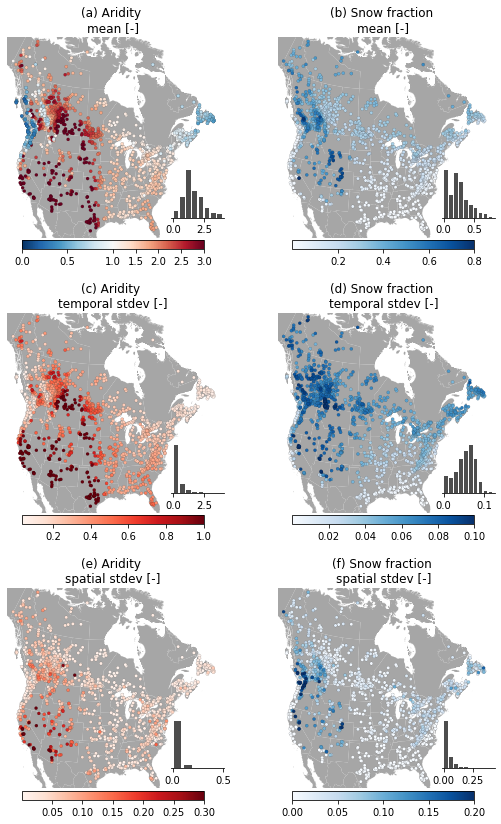

In [47]:
fig, axs = plt.subplots(3,2,figsize=(8.27,11.69))
have_borders=True

# (a) mean aridity
ax = axs[0,0]; color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'aridity1_mean'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
           cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
           legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp['aridity1_mean']<1].sort_values(by='aridity1_mean', ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(a) Aridity \nmean [-]')

# (c) time std aridity
ax = axs[1,0]; color = 'Reds'; column = 'aridity1_std'; vmax = 1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(c) Aridity \ntemporal stdev [-]')

# (e) space std aridity
ax = axs[2,0]; color = 'Reds'; column = 'aridity2_std'; vmax = 0.3
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,0.5,num=6))
ax.set_title('(e) Aridity \nspatial stdev [-]')

# (b) mean snow fraction
ax = axs[0,1]; color = 'Blues'; column = 'fracsnow1_mean'; vmax = 0.8
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(b) Snow fraction \nmean [-]')

# (d) time std snow fraction
ax = axs[1,1]; color = 'Blues'; column = 'fracsnow1_std'; vmax = 0.1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(d) Snow fraction \ntemporal stdev [-]')

# (f) space std snow fraction
ax = axs[2,1]; color = 'Blues'; column = 'fracsnow2_std'; vmax = 0.2
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(f) Snow fraction \nspatial stdev [-]')

plt.tight_layout()
plt.savefig('./attributes_climate_dots_v2.png', dpi=300, bbox_inches='tight')